# Finding the conversion pattern in difficulty 2
I am able to match cipher texts in difficulty 2 ⇄ plain text, but I still can't find out the algorithm how the text is converted to cipher.

Updates (ver 2): Added a new pattern for word 'people'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import pickle
import h5py

# The official data directory `ciphertext-challenge-ii`
# and my private directory `cipher`
print(os.listdir("../input"))

plain = pd.read_csv('../input/ciphertext-challenge-ii/training.csv')
cipher = pd.read_csv('../input/ciphertext-challenge-ii/test.csv')

# Select difficlty 2
idx = cipher['difficulty'] == 2
cipher2 = cipher[idx]

# Cipher text -> plain text correspondance
# private file [secret 😝]
with h5py.File('../input/cipher/answer2.h5', 'r') as f:
    answer2 = f['answer2'][:]

['cipher', 'ciphertext-challenge-ii']


In [2]:
# Find out how each character is mapped to cipher character
# assuming that jth character in plain text is mappted to jth character in cipher

n_cipher = cipher2.shape[0]
transition = {}

for i in range(n_cipher):
    # knowing which text_plain corresponds to text_cipher
    text_cipher = cipher2.ciphertext.iloc[i]
    text_plain = plain.text.iloc[answer2[i]] 
    
    # remove padding
    pad = (len(text_cipher) - len(text_plain)) // 2
    text_cipher = text_cipher[pad:(pad + len(text_plain))]

    for j, w in enumerate(text_plain):
        w_cipher = text_cipher[j]
        if w not in transition:
            transition[w] = set()
        transition[w].add(w_cipher)
        # character w become characeter w_cipher in the cipher text

# 'e' in plain text is mapped to:
dest_e = transition['e']
print('e → ', dest_e)

e →  {'z', 'i', 'a', 'p', 's', 'y'}


The mapping is not 1:1 but there are only 6 possibilities

In [3]:
# Count the frequently of the mapped character

def count_destination(c_plain):
    """
    
    Count the distribution of character that c_plain is mapped to
    
    Returns:
        count (dict): count[c] is the frequency that c_plain is mapped to c
    """
    count = {}

    n = len(answer2)
    for i in range(n):
        i_plain = answer2[i]
        text_plain = plain.text.iloc[i_plain]
        text_cipher = cipher2.ciphertext.iloc[i]
    
        # remove padding
        pad = (len(text_cipher) - len(text_plain)) // 2
        text_cipher = text_cipher[pad:(pad + len(text_plain))]
    
        for j in range(len(text_plain)):
            if text_plain[j] == c_plain:
                c = text_cipher[j]
                if c not in count:
                    count[c] = 0
                count[c] += 1

    return count

{'i': 157018, 'y': 314269, 's': 156769, 'a': 156836, 'p': 156721, 'z': 313939}


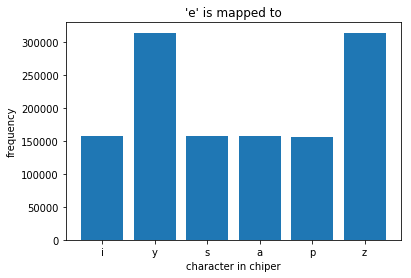

In [4]:
char = 'e'
count = count_destination(char)

print(count)
x = list(count.keys())
y = list(count.values())

plt.title("'%s' is mapped to" % char)
plt.xlabel('character in chiper')
plt.ylabel('frequency')
plt.bar(x, y)
plt.show()

1. 'e' is not mapped uniformly to {i, y, s, a, p, z}
2. y, z are exactly twice more frequent than i s a p

What kind of algorithms can do this?

* Some classical ciphers use multiple mapping periodically, e.g., *i* mod 6 rule is applied to *i*th character -- if *i*th character is 'e' and *i* = 0 mod 6, then 'e' -> i for example. But then {i, y, s, a, p, z} must appear evenly.
(*i* mod 6 is the remainder devided by 6; i % 6 in many computer language)

* Another idea is that the rule is selected by the previous character, if previous character is 'a' then 'e' is mapped to 'i', for example. It can be generalized to using nth character on the left. This can explain inhomogenous distribution, but cannot explain the exact 1:2:1:1:2 distribution in the figure.

Trying out with more characters, I find,
* Some characters are always mapped to 1 character in cipher;
* when the densination of mapping have 6 candidates, it is always 1:1:1:1:2:2 ratio

Then, how about assuming that rule (*i* **mod 8**) mod 6 is applied to *i*th character? i mod 8 = 0, 6 use rule 0, and i mod 8 1, 7 use rule 1, exaclty twice more frequently than rule 2 3 4 5.

In [5]:
# convert 6 possibilities to integers for 'e'
dest_number = {'a': 0, 'i':1, 'p':2, 's':3, 'y':4, 'z':5}

n = len(answer2)
period = 8
reminder = []
pos_plain = []
pos_cipher = []
dest = []


# prepair dictionary for 8 cases of i mod 8
for i in range(period):
    reminder.append({})

for i in range(n_cipher):
    text_cipher = cipher2.ciphertext.iloc[i]
    text_plain = plain.text.iloc[answer2[i]]

    # remove padding
    pad = (len(text_cipher) - len(text_plain)) // 2
    text_cipher = text_cipher[pad:(pad + len(text_plain))]

    for j, w in enumerate(text_plain):
        if w == 'e':
            n_cipher = cipher2.shape[0]
count = {}

test = 0

for i in range(n_cipher):
    text_cipher = cipher2.ciphertext.iloc[i]
    text_plain = plain.text.iloc[answer2[i]]

    # remove padding
    pad = (len(text_cipher) - len(text_plain)) // 2
    text_cipher = text_cipher[pad:(pad + len(text_plain))]

    for j, w in enumerate(text_plain):
        if w == 'e':
            # character w become characeter w_cipher in the cipher text
            w_cipher = text_cipher[j]

            location = pad + j # position in cipher text
            location_plain = j # position in plain text
            # using the location in the plain text does't change the result

            pos_cipher.append(location) # position of the character in cipher text
            pos_plain.append(location_plain)
            dest.append(dest_number[w_cipher]) # character in cipher
            
            count = reminder[location % period]
            
            if w_cipher not in count:
                count[w_cipher] = 0
            count[w_cipher] += 1
            
pos_plain = np.array(pos_plain)
pos_cipher = np.array(pos_cipher)
dest = np.array(dest)

for i in range(period):
    print(reminder[i])

{'s': 19770, 'a': 19420, 'z': 38987, 'i': 19821, 'y': 39196, 'p': 19487}
{'a': 19682, 'y': 39160, 'z': 39400, 's': 19282, 'i': 19544, 'p': 19862}
{'p': 19496, 'y': 39206, 'i': 19722, 's': 19657, 'z': 39150, 'a': 19511}
{'y': 39211, 'p': 19617, 's': 19548, 'i': 19538, 'z': 39197, 'a': 19528}
{'i': 19435, 'y': 39314, 'p': 19447, 'a': 19579, 'z': 39638, 's': 19667}
{'z': 39281, 'y': 39429, 'a': 19631, 'p': 19545, 'i': 19791, 's': 19591}
{'z': 39232, 'y': 39496, 's': 19476, 'i': 19546, 'a': 19732, 'p': 19598}
{'y': 39257, 'a': 19753, 's': 19778, 'z': 39054, 'i': 19621, 'p': 19669}


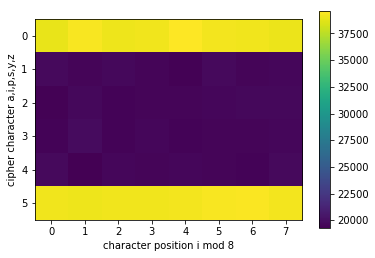

In [6]:
frequency2 = np.zeros((len(dest_e), period))
for i, c in enumerate(dest_e): # {'a', 'i', 'p', 's', 'y', 'z'}
    for j in range(period):
        frequency2[i, j] = reminder[j][c]

plt.xlabel('character position i mod 8')
plt.ylabel('cipher character a,i,p,s,y,z')
plt.imshow(frequency2)
plt.colorbar()
plt.show()

No......, the mapping does not depend on the position of the character mod 8.

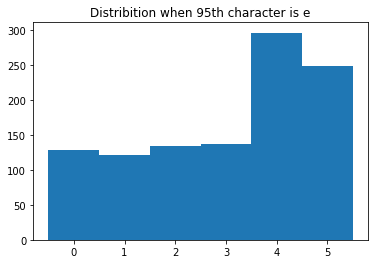

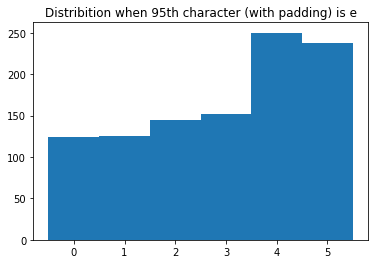

In [7]:
# The desnination of mapping when the position of 'e' is 95
idx = pos_plain == 95

plt.title('Distribition when 95th character is e')
plt.hist(dest[idx], np.arange(7) - 0.5)
plt.show()

idx = pos_cipher == 95
plt.title('Distribition when 95th character (with padding) is e')
plt.hist(dest[idx], np.arange(7) - 0.5)
plt.show()

The mapping rule does not depend on the character position. There are 6 posibilities even the position is the same. We have to think other rules.

# Find a pattern in bigram

(Not exactly a bigram, first two characters in words)



In [8]:
# Assigning a number to 6 characters
# 'p' and 'e' have 6 possibilities each
p_to_num = {}
for i, c in enumerate(transition['p']):
    p_to_num[c] = i

e_to_num = {}
for i, c in enumerate(transition['e']):
    e_to_num[c] = i
    
print('p →', p_to_num)
print('e →', e_to_num)

p → {'r': 0, 'a': 1, 'q': 2, 'h': 3, 's': 4, 'k': 5}
e → {'z': 0, 'i': 1, 'a': 2, 'p': 3, 's': 4, 'y': 5}


In [9]:
n = len(answer2)

count = np.zeros((len(p_to_num), len(e_to_num)))

for i in range(n):
    i_plain = answer2[i]
    text_plain = plain.text.iloc[i_plain]
    text_cipher = cipher2.ciphertext.iloc[i]
    
    # remove padding
    pad = (len(text_cipher) - len(text_plain)) // 2
    text_cipher = text_cipher[pad:(pad + len(text_plain))]
    
    # split text into words, '7' is the space in the cipher
    words = text_plain.split(' ')
    words_cipher = text_cipher.split('7')
    assert(len(words) == len(words_cipher))

    for j, w in enumerate(words):
        if len(w) >= 2 and w[0] == 'p' and w[1] == 'e': # word starting from pe, e.g. people
            w_cipher = words_cipher[j]
            count[p_to_num[w_cipher[0]], e_to_num[w_cipher[1]]] += 1

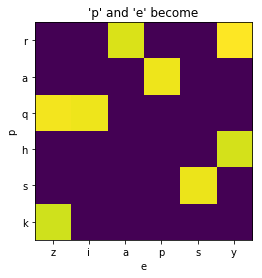

In [10]:
plt.title("'p' and 'e' become")
plt.xlabel('e')
plt.ylabel('p')
plt.xticks(np.arange(len(transition['e'])), transition['e'])
plt.yticks(np.arange(len(transition['p'])), transition['p'])
plt.imshow(count)
plt.show()

I found some nonuniform pattern. For words starting from 'pe', like people, not all 36 patterns appear. 

'pe' can become 'qi' or 'qz' in cipher, but not qa, qs, qy, qp. I hope this gives some clue.